In [11]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder


In [12]:
def preprocess_data(data, target_col, discrete_cols, past_steps=240, future_steps=240):
    # 编码离散型变量
    label_encoders = {col: LabelEncoder() for col in discrete_cols}
    for col in discrete_cols:
        data[col] = label_encoders[col].fit_transform(data[col])

    # 构建序列
    X_cont, X_cat, y = [], [], []
    for i in range(len(data) - past_steps - future_steps):
        X_cont.append(data.iloc[i:i+past_steps].drop(discrete_cols + [target_col], axis=1).values)
        X_cat.append(data.iloc[i:i+past_steps][discrete_cols].values)
        y.append(data.iloc[i+past_steps:i+past_steps+future_steps][target_col].values)

    return np.array(X_cont), np.array(X_cat), np.array(y), label_encoders


# 示例



In [13]:
#read csv
data = pd.read_csv('train_data.csv')
data = data.dropna()
data.drop(['dteday', 'instant'], axis=1, inplace=True)

# 指定离散型变量列
discrete_cols = ['season', 'yr','mnth','hr','holiday','weekday','workingday','weathersit']  # 示例：季节和天气情况为离散型变量

X_cont_train, X_cat_train, y_train, label_encoders = preprocess_data(data, 'cnt', discrete_cols)

test_data = pd.read_csv('test_data.csv')
test_data = test_data.dropna()
test_data.drop(['dteday', 'instant'], axis=1, inplace=True)

X_cont_test, X_cat_test, y_test, _ = preprocess_data(test_data, 'cnt', discrete_cols)

In [14]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# 转换为 Tensor
X_cont_train_tensor = torch.tensor(X_cont_train, dtype=torch.float32)
X_cat_train_tensor = torch.tensor(X_cat_train, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_cont_test_tensor = torch.tensor(X_cont_test, dtype=torch.float32)
X_cat_test_tensor = torch.tensor(X_cat_test, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# 创建 DataLoader
train_dataset = TensorDataset(X_cont_train_tensor, X_cat_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_cont_test_tensor, X_cat_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset)


In [15]:
import torch.nn as nn

class LSTMModelWithEmbedding(nn.Module):
    def __init__(self, input_dim, embedding_dims, hidden_dim, num_layers, output_dim):
        super(LSTMModelWithEmbedding, self).__init__()

        # 创建嵌入层
        self.embeddings = nn.ModuleList([
            nn.Embedding(num_categories, embedding_dim)
            for num_categories, embedding_dim in embedding_dims
        ])

        # LSTM 层
        total_embedding_dim = sum(embedding_dim for _, embedding_dim in embedding_dims)
        self.lstm = nn.LSTM(input_dim + total_embedding_dim, hidden_dim, num_layers, batch_first=True)

        # 全连接层
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x_cont, x_cat):
        # 嵌入层处理离散型变量
        embedded = [embedding(x_cat[:, :, i]) for i, embedding in enumerate(self.embeddings)]
        embedded = torch.cat(embedded, dim=-1)  # 拼接所有嵌入层输出

        # 拼接连续型特征和嵌入特征
        x = torch.cat((x_cont, embedded), dim=-1)

        # 输入 LSTM
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # 取最后时间步的输出

        # 输出层
        out = self.fc(out)
        return out

In [16]:
input_dim = X_cont_train.shape[2]  # 连续特征数
hidden_dim = 64
num_layers = 3
output_dim = 240  # 预测 240 小时
embedding_dims = [(4, 2), (3, 2)]  # 示例：嵌入尺寸 (类别数量, 嵌入维度)

# 初始化模型
model = LSTMModelWithEmbedding(input_dim, embedding_dims, hidden_dim, num_layers, output_dim)


In [17]:
import torch.optim as optim

# 损失函数和优化器
criterion = nn.MSELoss()
criterion_mae = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [18]:
# 训练模型
maes=[]
mses=[]
def train_model(model, train_loader, criterion, optimizer, epochs):
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for X_cont_batch, X_cat_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_cont_batch, X_cat_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()

            optimizer.step()
            train_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader):.4f}")

# 开始训练
train_model(model, train_loader, criterion, optimizer, epochs=20)


Epoch 1/20, Train Loss: 29379.2120
Epoch 2/20, Train Loss: 27517.4195
Epoch 3/20, Train Loss: 27384.3825
Epoch 4/20, Train Loss: 27085.6677
Epoch 5/20, Train Loss: 26223.4239
Epoch 6/20, Train Loss: 23374.2891
Epoch 7/20, Train Loss: 22081.1636
Epoch 8/20, Train Loss: 18777.3102
Epoch 9/20, Train Loss: 18656.0959
Epoch 10/20, Train Loss: 17588.9570
Epoch 11/20, Train Loss: 22011.3135
Epoch 12/20, Train Loss: 19299.7750
Epoch 13/20, Train Loss: 20645.0399
Epoch 14/20, Train Loss: 17196.7606
Epoch 15/20, Train Loss: 18368.3092
Epoch 16/20, Train Loss: 14897.4068
Epoch 17/20, Train Loss: 18426.5434
Epoch 18/20, Train Loss: 15635.8487
Epoch 19/20, Train Loss: 15134.5377
Epoch 20/20, Train Loss: 14353.5921


In [19]:
# 测试模型
model.eval()
test_loss = 0.0
predicts=[]
real=[]
mse=[]
mae=[]
with torch.no_grad():
    for X_cont_batch, X_cat_batch, y_batch in test_loader:
        outputs = model(X_cont_batch, X_cat_batch)
        predicts.append(outputs)
        real.append(y_batch)
        loss = criterion(outputs, y_batch)
        for i in range(len(y_batch)):
                maes.append(criterion_mae(outputs[i],y_batch[i]).item())
                mses.append(criterion(outputs[i],y_batch[i]).item())
        test_loss += loss.item()
print(f"Test Loss: {test_loss / len(test_loader)}")


Test Loss: 29860.06908249628


MAE Mean:178.06983184814453,MAE Std:33.82572351355109
MSE Mean:45734.5140625,MSE Std:15703.9631500155


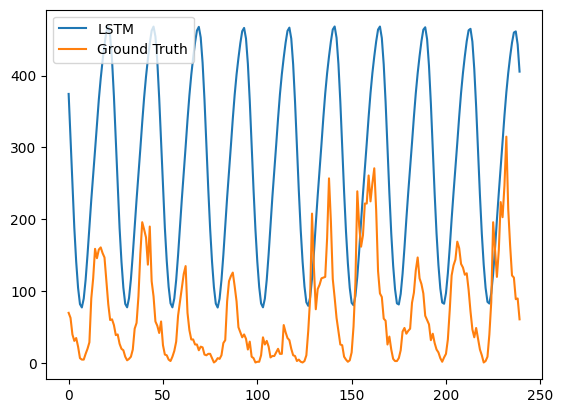

In [21]:
selectedmae=[]
selectedmse=[]
for i in range(5):
    idx=np.random.randint(0,len(predicts))
    mae=maes[idx]
    mse=mses[idx]
    selectedmae.append(mae)
    selectedmse.append(mse)
maestd=np.std(selectedmae)
msestd=np.std(selectedmse)
maemean=np.mean(selectedmae)
msemmean=np.mean(selectedmse)
print(f"MAE Mean:{maemean},MAE Std:{maestd}")
print(f"MSE Mean:{msemmean},MSE Std:{msestd}")
import matplotlib.pyplot as plt
datax=[i for i in range(240)]
datay=outputs[-1].numpy()
plt.plot(datax,datay,label='LSTM')
datay=y_batch[-1].numpy()
plt.plot(datax,datay,label='Ground Truth')
#left up corner
plt.legend(loc='upper left')
#background color white
plt.gca().set_facecolor('white')
plt.show()